# Custom loss function in GBM demo

#### Veronika Maurerova (veronika.maurerova@h2o.ai, [@MaureVer](https://twitter.com/MaureVer))

In H2O GBM implementation distributions and loss functions are tightly coupled. In the algorithm, a loss function is specified using the distribution parameter. When specifying the distribution, the loss function is automatically selected as well.

Usually, the loss functions are symmetric around some value. For example, Gaussian "Normal" distribution use Mean Squared Error Loss, which is symmetric around mean.

![gaussian](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/_images/gaussian.png)

Usually, the loss function is symmetric around a value. In some prediction problems, though, asymmetry in the loss function can improve results, for example, when you know that some kind of error is more undesirable than others (usually negative vs. positive error). You can use weights to cover some of these cases, but that is not suitable for more complicated calculations.

You can get more information about customization of loss function [here](https://towardsdatascience.com/custom-loss-functions-for-gradient-boosting-f79c1b40466d), where is an example using LightGBM library. XGBoost library also provides this possibility.

In H2O you can upload custom distribution and also customized loss function calculation from version 3.26.0.1. 

The documentation for custom distribution is available [here](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/custom_distribution_func.html)

See the example below.

In [2]:
# import h2o and other libraries
import h2o
import pandas as pd
import datetime

from h2o.estimators.gbm import H2OGradientBoostingEstimator

# init h2o
h2o.init()

versionFromGradle='3.27.0',projectVersion='3.27.0.99999',branch='maurever_custom_dist_demo',lastCommitHash='dae7042674ddb02f23d692564d919b7f90a4d986',gitDescribe='jenkins-master-4738-dirty',compiledOn='2019-07-19 11:30:13',compiledBy='mori'
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.3" 2019-04-16; OpenJDK Runtime Environment (build 11.0.3+7-post-Debian-5); OpenJDK 64-Bit Server VM (build 11.0.3+7-post-Debian-5, mixed mode, sharing)
  Starting server from /home/mori/Documents/h2o/code/h2o-3/build/h2o.jar
  Ice root: /tmp/tmpi3vv_o_s
  JVM stdout: /tmp/tmpi3vv_o_s/h2o_mori_started_from_python.out
  JVM stderr: /tmp/tmpi3vv_o_s/h2o_mori_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
versionFromGradle='3.27.0',projectVersion='3.27.0.99999',branch='maurever_custom_dist_demo'

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.27.0.99999
H2O cluster version age:,2 hours and 11 minutes
H2O cluster name:,H2O_from_python_mori_uivz42
H2O cluster total nodes:,1
H2O cluster free memory:,5.768 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


## Data 

To demonstrate how to customize loss function, we use [Store Item Demand Forecasting training dataset](https://www.kaggle.com/c/demand-forecasting-kernels-only/data) from Kaggle. 

**Data fields:**

- date - Date of the sale data. There are no holiday effects or store closures.
- store - Store ID
- item - Item ID
- sales - Number of items sold at a particular store on a particular date.

The goal is to forecast how many items will be sale in a store on a specific date. This task can be useful for example, for planning how many items to store in which shop to be available for customers, however with costs for space in the shop as low as possible. 

In [3]:
# load data 
data = pd.read_csv("../../smalldata/demos/item_demand.csv")
print(data.shape)
data.head()

(913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


## Data preprocessing

To predict a specific value, we need to prepare some new features. First split date to year, month, day. Then we make "lag" features one year back. From these features, we aggregate some other values.

In [4]:
# Transform date column
def prepare_date(data, date_column):
    data[date_column] = pd.to_datetime(data[date_column])
    index = pd.DatetimeIndex(data[date_column])
    data["year"] = index.year
    data["month"] = index.month
    data["day"] = index.day
    return data

# Create new features (lags, aggregated values based on lags)
def group_by_agg_lags(data):
    g = data.groupby(["store", "item"]).sales

    # lags older than 92 to be aple to prepare test data correctly 
    for i in range(92,366):
        data["lag_"+str(i)] = g.shift(i)
    data.dropna(inplace=True, axis=0)
    
    data["mean_last_year_week_7"] = data.iloc[:,266:274].mean(axis=1)
    data["mean_last_year_week_6"] = data.iloc[:,267:275].mean(axis=1)
    data["mean_last_year_week_5"] = data.iloc[:,268:276].mean(axis=1)
    data["mean_last_year_week_4"] = data.iloc[:,269:277].mean(axis=1)
    data["mean_last_year_week_3"] = data.iloc[:,270:278].mean(axis=1)
    data["mean_last_year_week_2"] = data.iloc[:,271:279].mean(axis=1)
    data["mean_last_year_week_1"] = data.iloc[:,272:280].mean(axis=1)
    data["moving_mean_last_year_week"] = data.iloc[:,280:287].mean(axis=1)
    data["sum_last_year_week"] = data.iloc[:,272:280].sum(axis=1)
    return data

In [5]:
# prepare date columns
data = prepare_date(data, "date")

# aggregate data, prepare lags, remove null rows
data = group_by_agg_lags(data)
print("New data shape:")
print(data.shape)

# split to train and test
train = data[data.date <= "2017-09-30"]
print("Training data shape:")
print(train.shape)

# last 3 month for testing
test = data[data.date > "2017-09-30"]
print("Testing data shape:")
print(test.shape)

# Upload prepared data to h2o 
train_h2o = h2o.H2OFrame(train)
test_h2o = h2o.H2OFrame(test)

New data shape:
(730500, 290)
Training data shape:
(684500, 290)
Testing data shape:
(46000, 290)
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


## Types of error

There could be two types of error:
- there are the fewer amount of items in a store
- there are the more amount of items in a store

If we use traditional Gaussian distribution to train model, the algorithm penalizes these two errors similarly. But for a manager of the stores could be more expensive not to sell an item, than store more items in a particular shop. Thus the first error is more critical to penalize during the training than the second one.

In [26]:
# Functions to analyse and plot results
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.facecolor'] = 'white'

import matplotlib
from matplotlib.dates import DateFormatter

import numpy as np

# evaluate number of good predictions
def evaluate(test, predictions):
    predictions["actual"] = test.sales.values
    predictions.columns = ["prediction", "actual"]
    predictions["date"] = test.date.values
    predictions["item"] = test.item.values
    predictions["store"] = test.store.values
    predictions["residual"] = predictions.actual - predictions.prediction
    predictions["sresidual"] = predictions.residual / np.sqrt(predictions.actual)
    predictions["fit"] = 0
    # if residual is positive there are not enough items in the store
    predictions.loc[predictions.residual > 0, "fit"] = 0
    # if residual is zero or negative there are enough or more items in the store
    predictions.loc[predictions.residual <= 0, "fit"] = 1
    items = predictions.shape[0]
    more_or_perfect = sum(predictions.fit)
    less = items - more_or_perfect
    return (items, less, more_or_perfect)

# print result of evaluation
def print_evaluation(predictions, less, more_or_perfect):
    # set if no figure on output
    # %matplotlib inline

    #create scatter plot to show numbers of the errors
    name = ["fewer", "more or perfect"]
    count = [less, more_or_perfect]
    rank = [-4, 4]

    fig, ax = plt.subplots(figsize=(8,5))
    ax.axis([-10,10,-14000,90000])
    ax.scatter(rank,count,s=(count*2000),marker='o', c=["#c44e52","#55a868"])

    for n,c,r in zip(name, count, rank):
        plt.annotate("{}".format(c),xy=(r, c), ha="center", va="center", color="white", weight='bold', size=15)
        plt.annotate(n ,xy=(r, c), xytext=(0,10),
                 textcoords="offset points", ha="center", va="bottom", color="white", weight='bold', size=12)
    plt.title("Ratio between acceptable and nonacceptable predictions", weight='bold', size=20)
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(20,10))
    n, bins, patches = plt.hist(x=predictions.sresidual, bins='auto')
    plt.grid(axis='both')
    plt.xlabel('Value of residual', size=20)
    plt.ylabel('Frequency', size=20)
    plt.title('Histogram of standardized residuals \n mean: %f\n variance: %f'%(np.mean(predictions.sresidual), np.var(predictions.sresidual)), weight='bold', size=20)
    maxfreq = n.max()
    plt.ylim(top=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    for i in range(len(patches)):
        if bins[i] > 0 and round(bins[i+1]) >= 0:
            patches[i].set_facecolor('#c44e52')
        else:
            patches[i].set_facecolor('#55a868')
    plt.show()
    
# residual analysis
def print_residuals(predictions, predictions_custom):
    # histograms
    plt.figure(figsize=(20,10))
    n, bins, patches = plt.hist(x=[predictions.sresidual, predictions_custom.sresidual], 
                                bins='auto', label=['residual', 'residual custom'])
    plt.grid(axis='both')
    plt.xlabel('Value of standardized residual', size=22)
    plt.ylabel('Frequency', size=20)
    plt.title('Histograms of standardized residuals', weight='bold', size=22)
    plt.legend(loc='upper right')
    maxfreq = n[0].max() if n[0].max() > n[1].max() else n[1].max()
    plt.ylim(top=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    plt.show() 
    
    # actual vs. predicted
    
    f = plt.figure(figsize=(30,10))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.scatter(predictions.prediction, predictions.actual,  
            s = 10, label = 'Gaussian', alpha=0.7) 
    ax.scatter(predictions_custom.prediction, predictions_custom.actual, 
            s = 10, label = 'Custom', alpha=0.7) 
    plt.grid(axis='both')
    ax.set_xlabel('Predicted', size=20)
    ax.set_ylabel('Actual', size=20)
    ax.legend(loc = 'upper right')   
    ax.set_title("Predicted vs. Actual", weight='bold', size=22) 
    
    # residual error 
    ax2.scatter(predictions.prediction, predictions.sresidual, 
            s = 10, label = 'Gaussian', alpha=0.7) 
    ax2.scatter(predictions_custom.prediction, predictions_custom.sresidual, 
            s = 10, label = 'Custom', alpha=0.7) 
    plt.hlines(y = 0, xmin = 0, xmax = 200, linewidth = 2)
    plt.grid(axis='both')
    ax2.set_xlabel('Prediction', size=20)
    ax2.set_ylabel('Standardized residual', size=20)
    ax2.legend(loc = 'upper right')   
    ax2.set_title("Standardized residual errors", weight='bold', size=22) 
    plt.show() 
    
# prediction analysis
def print_predictions(predictions, predictions_custom, item, store):
    one_item_data = predictions[(predictions.item==item) & (predictions.store==store)]
    one_item_data_custom = predictions_custom[(predictions_custom.item==item) & (predictions_custom.store==store)]
    fig, ax = plt.subplots(figsize=(30,10))
    ax.set_title(("Prediction vs. Actual item: %d store: %d")%(item, store), weight='bold', size=22)
    ax.set_xlabel('Date', size=20)
    ax.set_ylabel('Number of sold items', size=20)
    plt.grid(axis='both')
    plt.xticks(rotation=70)
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%Y"))
    ax.xaxis.set_minor_formatter(DateFormatter("%d-%m-%Y"))
    ax.plot_date(one_item_data.date, one_item_data.prediction, "o:", alpha=0.6, ms=10, label="predicted - Gaussian")
    ax.plot_date(one_item_data_custom.date, one_item_data_custom.prediction, "o:", ms=10, alpha=0.6, label="predicted - custom")
    ax.plot_date(one_item_data.date, one_item_data.actual, "o", markersize=10, label="actual")
    ax.legend(loc='upper right')
    
def plot_scoring_history(history_mm, history_cmm):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_title("Training scoring history", weight='bold', size=22)
    ax.set_xlabel('Number of trees', size=20)
    ax.set_ylabel('Custom metric', size=20)
    plt.grid(axis='both')
    ax.plot(history_mm, "o:", ms=10, label="Gaussian distribution & custom metric")
    ax.plot(history_cmm, "o:", ms=10, label="Custom distribution & custom metric")
    ax.legend(loc='upper right')

## Gaussian Distribution - symmetric

To use Gaussian distribution and Squared error loss function we need only set the ``distribution`` parameter to ``gaussian``.

In [7]:
# Train GBM model with Gaussian distribution
gbm_gaussian = H2OGradientBoostingEstimator(model_id="sales_model",
                                     ntrees=50,
                                     max_depth=5,
                                     score_each_iteration=True,
                                     distribution="gaussian")

gbm_gaussian.train(y="sales", x=train_h2o.names, training_frame=train_h2o)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


From the images below, we can see the numbers of two types of error are similar. Also, the distribution of residuals is symmetric around zero value.

To understand the histogram: More predicted items is a better error than the fewer predicted items. If a residual is positive, there are not enough items in the store. If a residual is negative or zero, there are enough items in the store.

gbm prediction progress: |████████████████████████████████████████████████| 100%


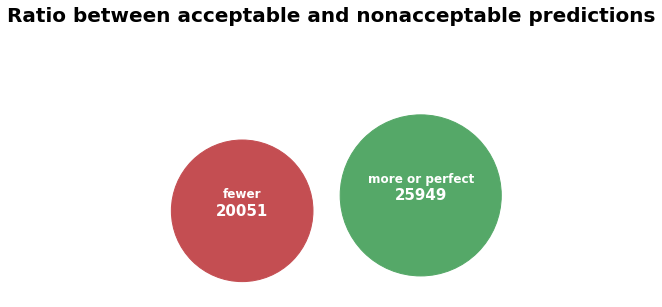

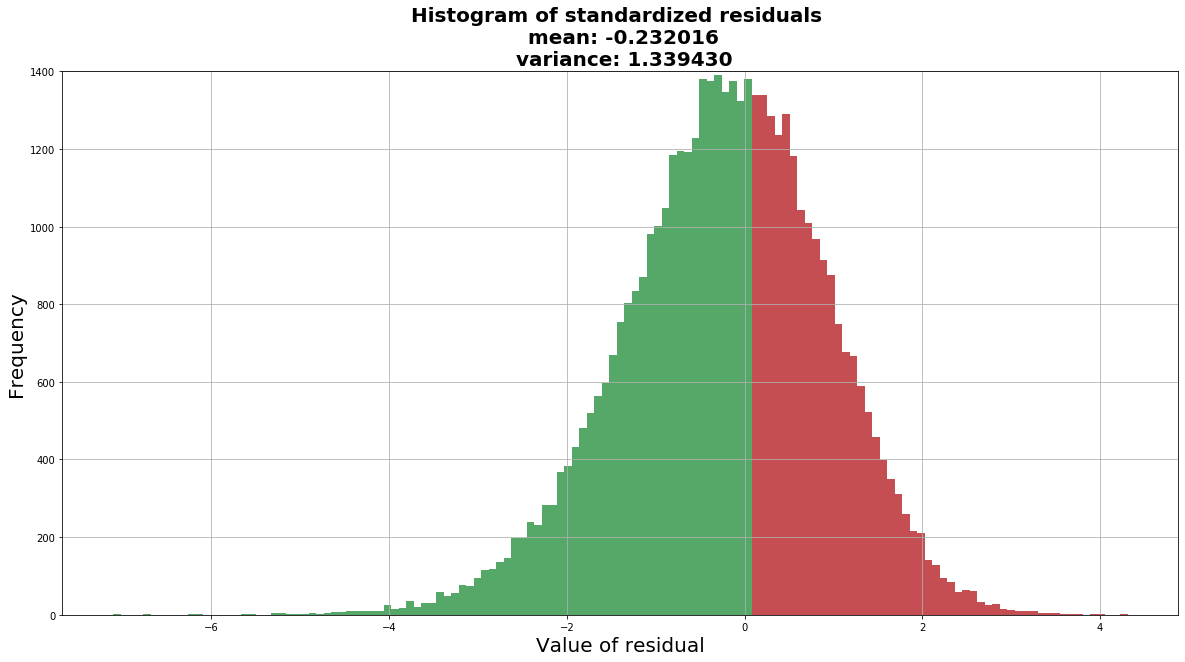

In [8]:
# Predict
predictions = gbm_gaussian.predict(test_data=test_h2o).as_data_frame()

# Evalute and print summary
items, less, more_or_perfect = evaluate(test, predictions)

print_evaluation(predictions, less, more_or_perfect)

## Custom Gaussian Distribution - asymmetric

To use Custom distribution and implement asymmetric loss function you need set the ``distribution`` parameter to ``custom``. Also, you need to upload our implementation of distribution and set the reference to this distribution to ``custom_distribution_func`` parameter.

You can implement an entirely your version of a distribution. However, you have to implement only different loss function calculation and that it is the reason to inherit from predefined ``CustomDistributionGaussian`` class and override only ``gradient`` function.

You can also use predefined ``CustomDistributionBernoulli`` and ``CustomDistributionMultinomial`` distributions for classification.

The whole source code is available [here](https://github.com/h2oai/h2o-3/blob/master/h2o-py/h2o/utils/distributions.py).

### Implementation of CustomDistributionGeneric

```python
class CustomDistributionGeneric(object):
    """
        Predefined generic distribution class to use for customization distribution.

        The class has four methods:
            - link: link function transforms the probability of response variable to a continuous scale that is unbounded
            - init: computes numerator and denominator of the initial value.
            - gradient: computes (Negative half) Gradient of deviance function at predicted value for an actual response
            - gamma: computes numerator and denominator of terminal node estimate

        For customization a loss function, the gradient and gamma methods are important.

        To customize a special type of problem we recommend you to inherit from predefined classes:
            - CustomDistributionGaussian - for regression problems
            - CustomDistributionBernoulli - for 2-class classification problems
            - CustomDistributionMultinomial - for n-class classification problems
    """
    def link(self):
        """
        Type of Link Function.

        :return: name of link function. Possible functions: log, logit, identity, inverse, ologit, ologlog, oprobit
        """
        return "identity"

    def init(self, w, o, y):
        """
        Contribution for initial value computation (numerator and denominator).

        :param w: weight
        :param o: offset
        :param y: response
        :return: list [weighted contribution to init numerator,  weighted contribution to init denominator]
        """
        return [0, 0]

    def gradient(self, y, f):
        """
        (Negative half) Gradient of deviance function at predicted value f, for actual response y.
        Important fot customization of a loss function.

        :param y: actual response
        :param f: predicted response in link space including offset
        :return: gradient
        """
        return 0

    def gamma(self, w, y, z, f):
        """
        Contribution for GBM's leaf node prediction (numerator and denominator).
        Important for customization of a loss function.

        :param w: weight
        :param y: actual response
        :param z: residual
        :param f: predicted response including offset
        :return: list [weighted contribution to gamma numerator, weighted contribution to gamma denominator]
        """
        return 1
```

### Implementation of CustomDistributionGaussian

```python

class CustomDistributionGaussian(CustomDistributionGeneric):
    """
        Predefined distribution class for regression problems.
    """

    def link(self):
        return "identity"

    def init(self, w, o, y):
        return [w * (y - o), w]

    def gradient(self, y, f):
        return y - f

    def gamma(self, w, y, z, f):
        return [w * z, w]
    
```

In [9]:
# Import predefined Gaussian distribution
from h2o.utils.distributions import CustomDistributionGaussian

# Define asymmetric loss distribution from Gaussian distribution 
class AsymmetricLossDistribution(CustomDistributionGaussian):

    def gradient(self, y, f):
        error = y - f
        # more predicted items is better error than the fewer predicted items
        # if residual is positive there are not enough items in the store
        # if residual is negative or zero there are enough items in the store
        # the positive error should be set as bigger! 
        return error if error < 0 else 10 * error
    
# upload distribution to h2o
name = "asymetric"
try:
    distribution_ref = h2o.upload_custom_distribution(AsymmetricLossDistribution, func_name="custom_"+name,
                                                      func_file="custom_"+name+".py")
except(IOError):
    print("This error occur in python 2.7 due to inspect package bug.")
    print("You can solve this problem by saving custom distribution class to a file with .py extension and loaded it to IPython separately.")

In [10]:
# Train GBM model with custom distribution    
gbm_custom = H2OGradientBoostingEstimator(model_id="custom_sales_model",
                                          ntrees=50,
                                          max_depth=5,
                                          score_each_iteration=True,
                                          distribution="custom",
                                          custom_distribution_func=distribution_ref)
    
gbm_custom.train(y="sales", x=train_h2o.names, training_frame=train_h2o)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In the images below, we can see the number of the first type error is rapidly lower than the amount of the second type error. On the residual histogram, we can also see mean residual value is a negative value, and even more values are shifted to the left. 

gbm prediction progress: |████████████████████████████████████████████████| 100%


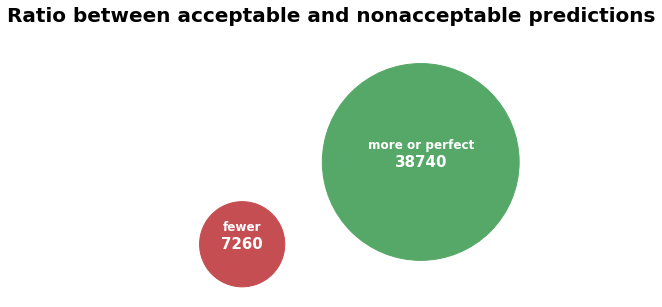

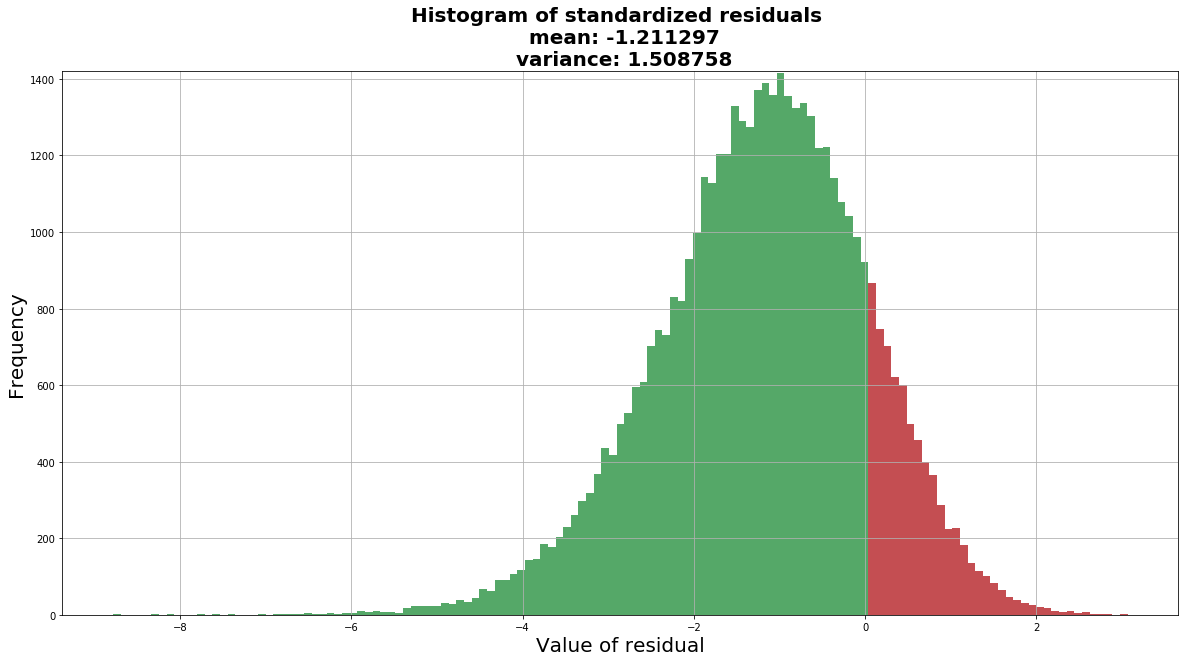

In [11]:
# Predict
predictions_custom = gbm_custom.predict(test_data=test_h2o).as_data_frame()

# Evalute and print summary
items_custom, less_custom, more_or_perfect_custom = evaluate(test, predictions_custom)
    
print_evaluation(predictions_custom, less_custom, more_or_perfect_custom)

## Residual analysis - comparation original and custom Gaussian Distribution

In [12]:
print("original vs. custom")
print("actual mean:", predictions.actual.mean(), predictions_custom.actual.mean())
print("prediction mean:", predictions.prediction.mean(), predictions_custom.prediction.mean())
print("prediction variance:", predictions.prediction.var(), predictions_custom.prediction.var())
print("residual mean:", predictions.sresidual.mean(), predictions_custom.sresidual.mean())
print("residual variance:", predictions.sresidual.var(), predictions_custom.sresidual.var())

original vs. custom
actual mean: 54.67754347826087 54.67754347826087
prediction mean: 55.605728508833494 62.65423281518972
prediction variance: 751.1812597544955 880.1840050964182
residual mean: -0.23201557505489037 -1.2112973067060355
residual variance: 1.3394591582670423 1.5087905508899855


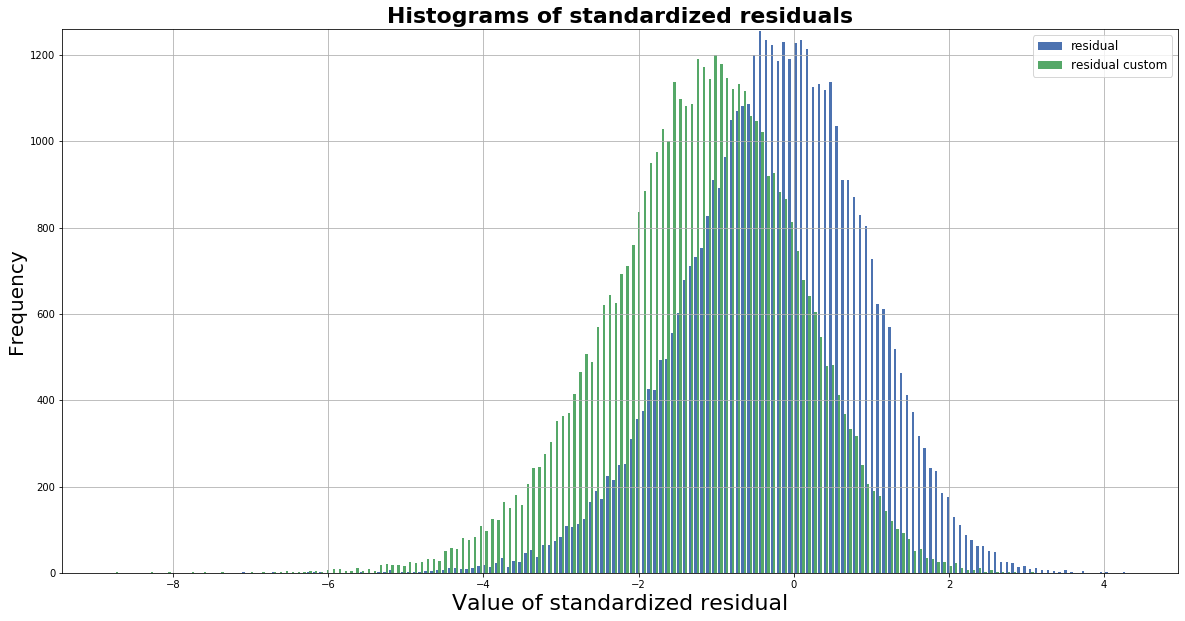

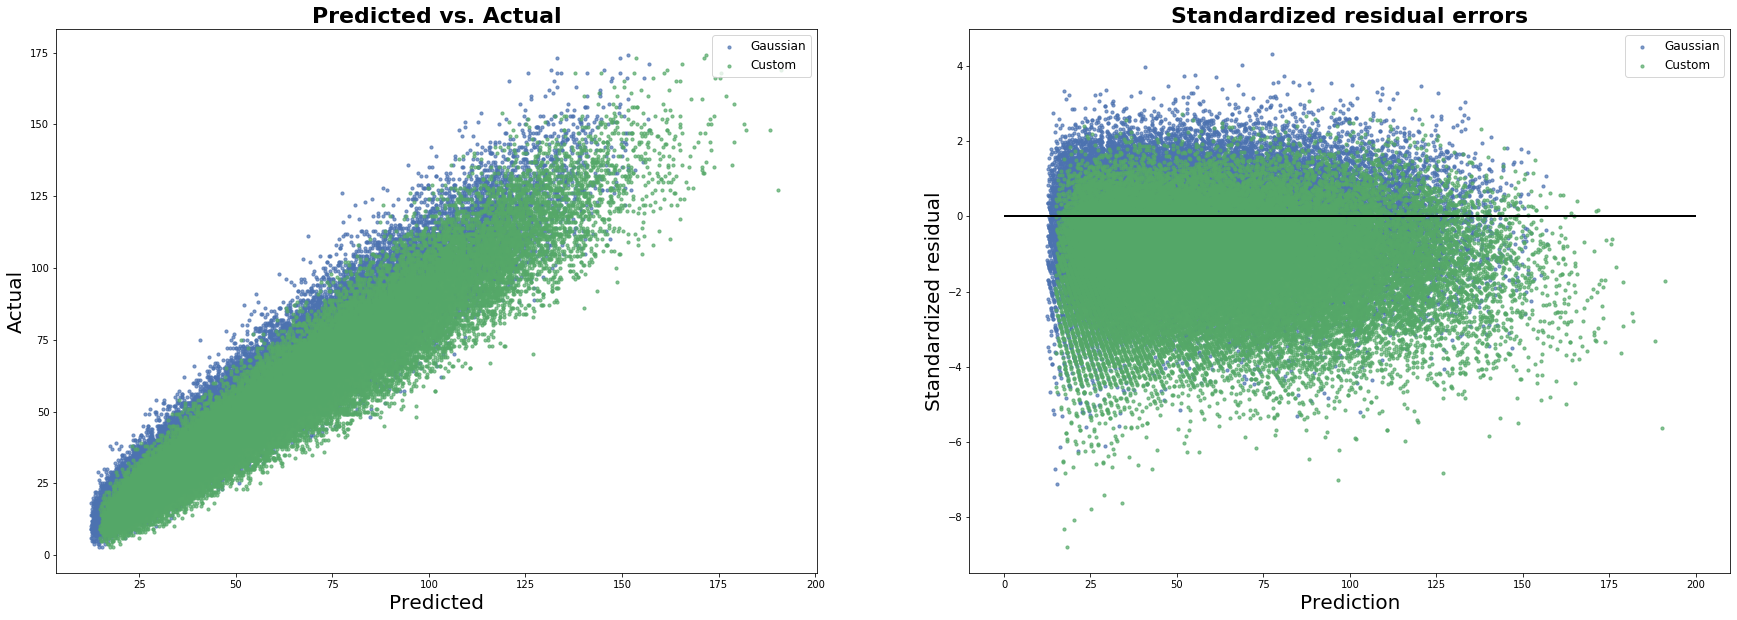

In [13]:
print_residuals(predictions, predictions_custom)

In these pictures, you can see a comparison of prediction on test data. The customized distribution causes the predictions are always larger than the predictions from the pure Gaussian prediction.

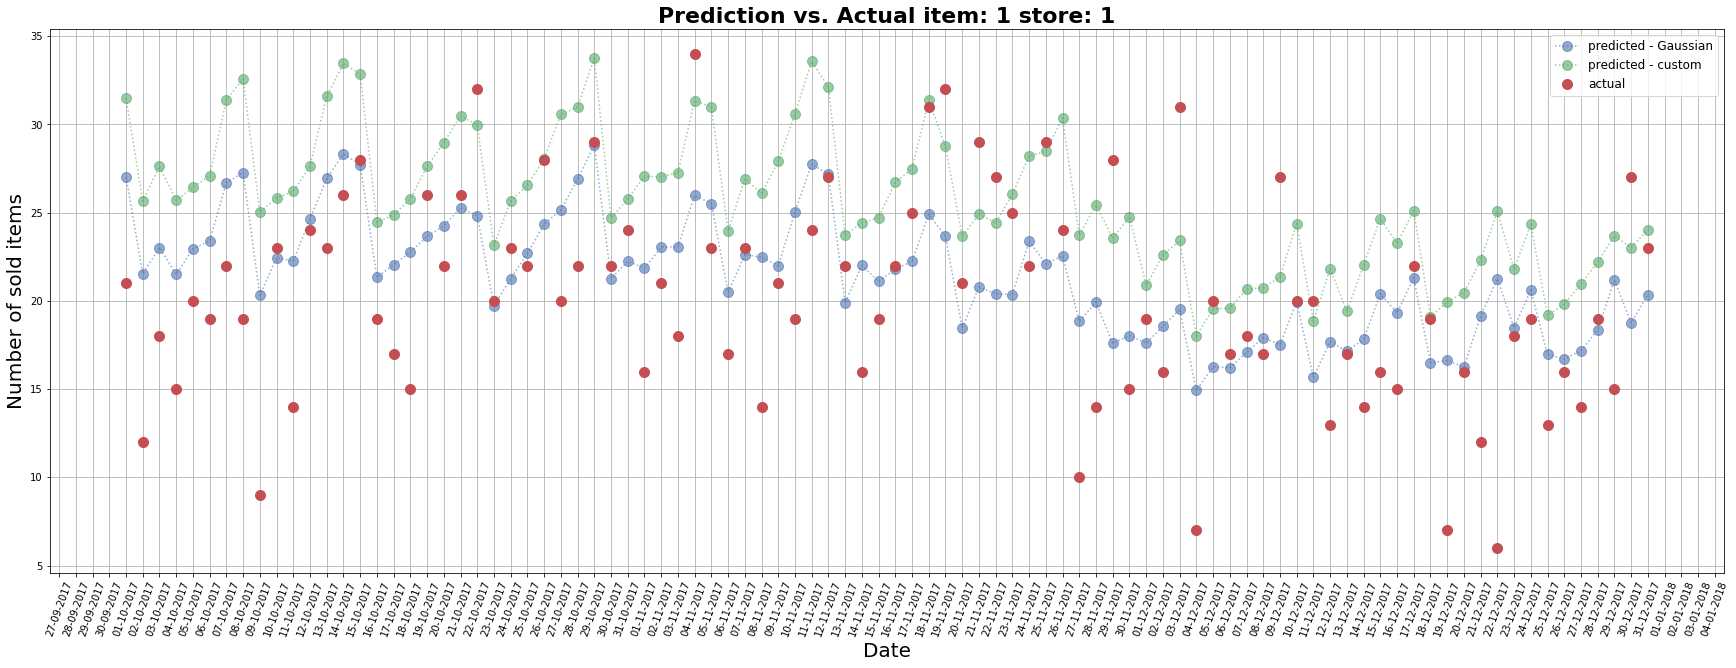

In [14]:
print_predictions(predictions, predictions_custom, 1, 1)

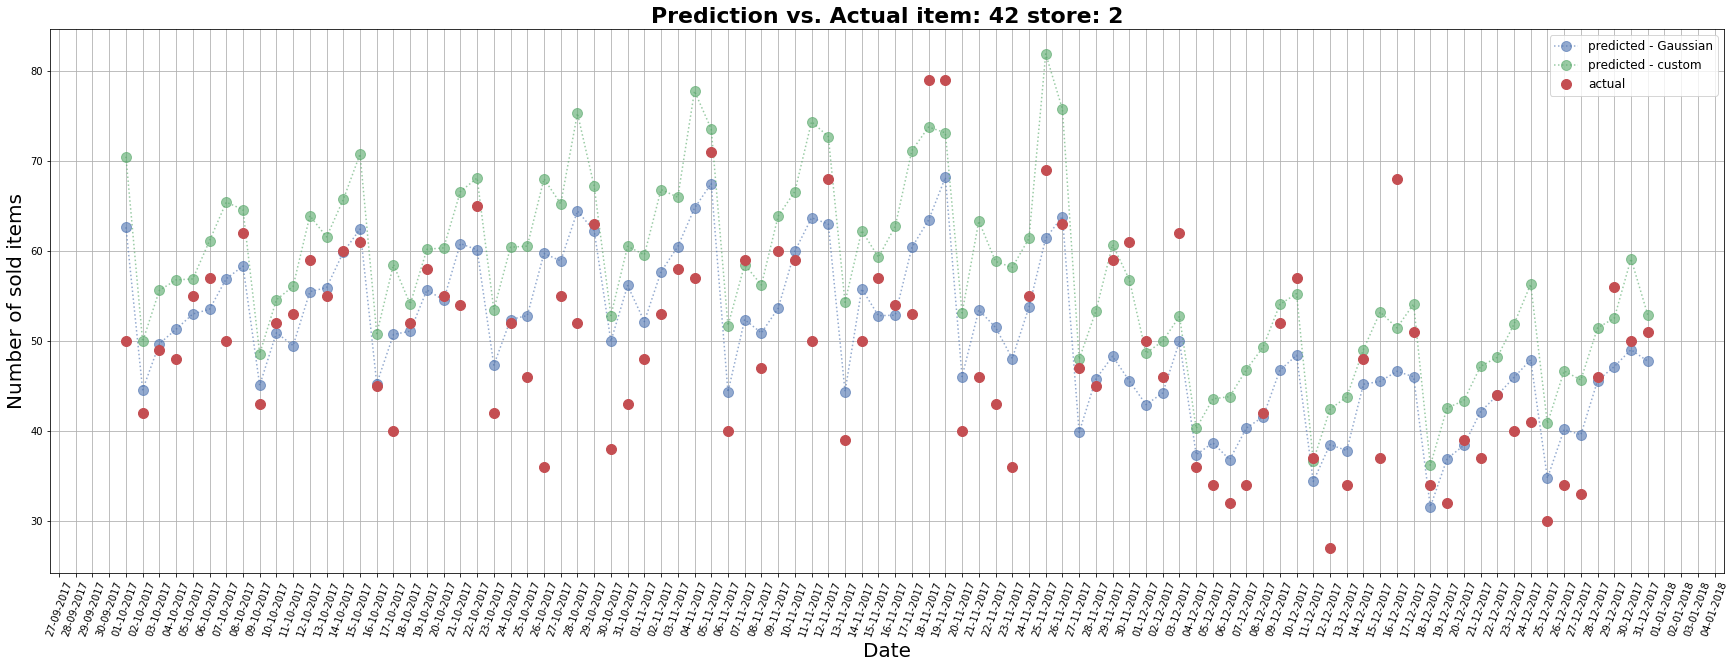

In [15]:
print_predictions(predictions, predictions_custom, 42, 2)

# Asymmetric custom distribution and custom metric together

If you want to measure the performance of model asymmetrically, you have to define your asymmetric custom metric too (more information and example [here](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/custom_metric_func.html)). 

In [16]:
# Custom asymmetric metric

class CustomAsymmetricMseFunc:
    def map(self, pred, act, w, o, model):
        error = act[0] - pred[0]
        # more predicted items is better error than the fewer predicted items
        # if residual is positive there are not enough items in the store
        # if residual is negative or zero there are enough items in the store
        # the positive error should be set as bigger error! 
        error = error if error < 0 else 10 * error
        return [error * error, 1]

    def reduce(self, l, r):
        return [l[0] + r[0], l[1] + r[1]]

    def metric(self, l):
        import java.lang.Math as math
        return math.sqrt(l[0] / l[1])

# Upload the custom metric
metric_ref = h2o.upload_custom_metric(CustomAsymmetricMseFunc,
                                          func_name="custom_mse",
                                          func_file="custom_mse.py")

In [17]:
# Train GBM model with custom metric
gbm_custom_mm = H2OGradientBoostingEstimator(model_id="custom_sales_model_mm",
                                            ntrees=50,
                                            max_depth=5,
                                            score_each_iteration=True,
                                            stopping_metric="custom",
                                            stopping_tolerance=0.1,
                                            stopping_rounds=5,
                                            distribution="gaussian",
                                            custom_metric_func=metric_ref)
    
gbm_custom_mm.train(y="sales", x=train_h2o.names, training_frame=train_h2o)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


gbm prediction progress: |████████████████████████████████████████████████| 100%


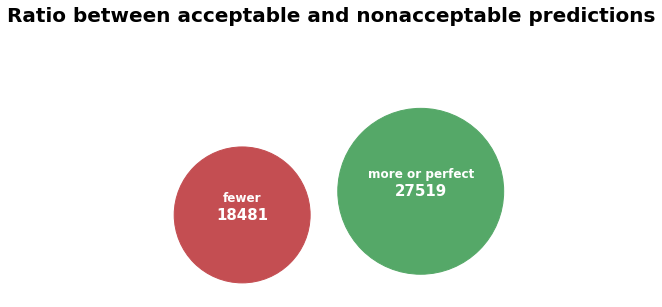

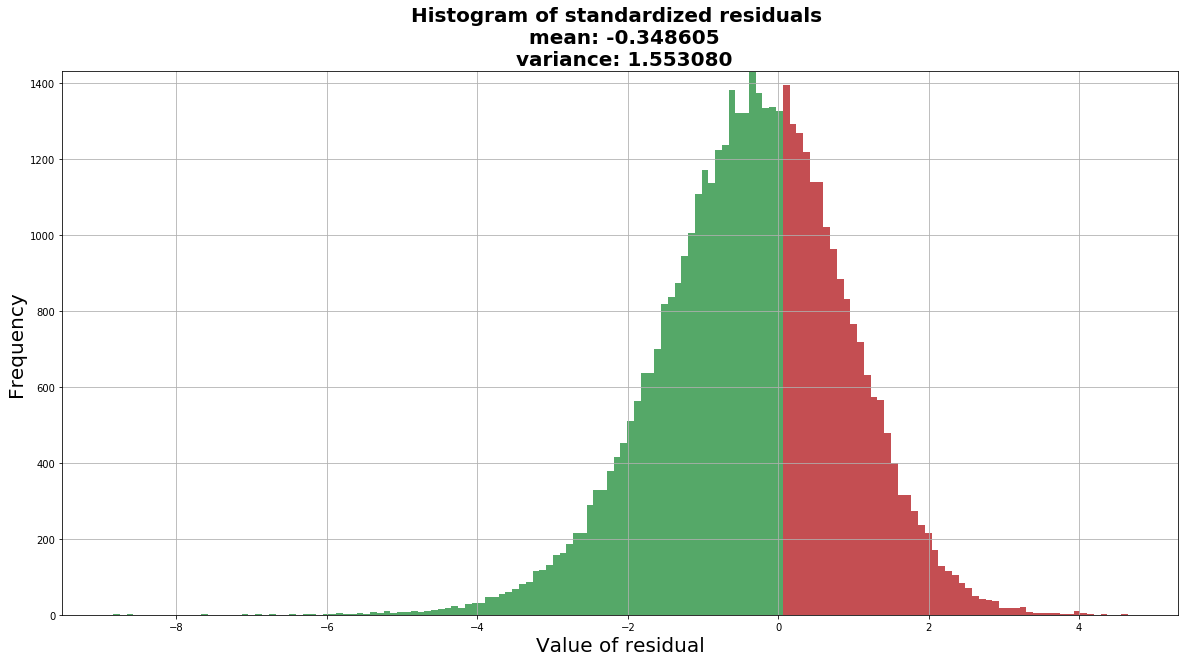

In [18]:
# Predict
predictions_custom_mm = gbm_custom_mm.predict(test_data=test_h2o).as_data_frame()

# Evalute and print summary
items_custom_mm, less_custom_mm, more_or_perfect_custom_mm = evaluate(test, predictions_custom_mm)
    
print_evaluation(predictions_custom_mm, less_custom_mm, more_or_perfect_custom_mm)

In [19]:
# Train GBM model with custom metric and distribution    
gbm_custom_cmm = H2OGradientBoostingEstimator(model_id="custom_sales_model_cmm",
                                            ntrees=50,
                                            max_depth=5,
                                            score_each_iteration=True,
                                            stopping_metric="custom",
                                            stopping_tolerance=0.1,
                                            stopping_rounds=5,
                                            distribution="custom",
                                            custom_metric_func=metric_ref,
                                            custom_distribution_func=distribution_ref)
    
gbm_custom_cmm.train(y="sales", x=train_h2o.names, training_frame=train_h2o)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


gbm prediction progress: |████████████████████████████████████████████████| 100%


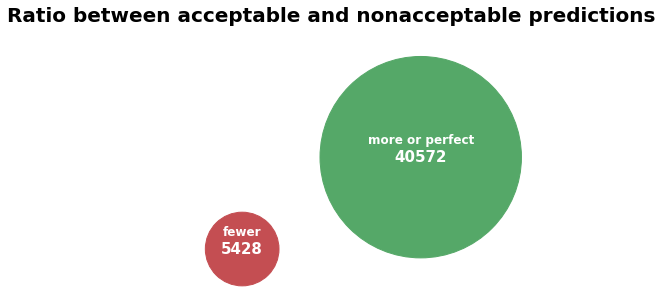

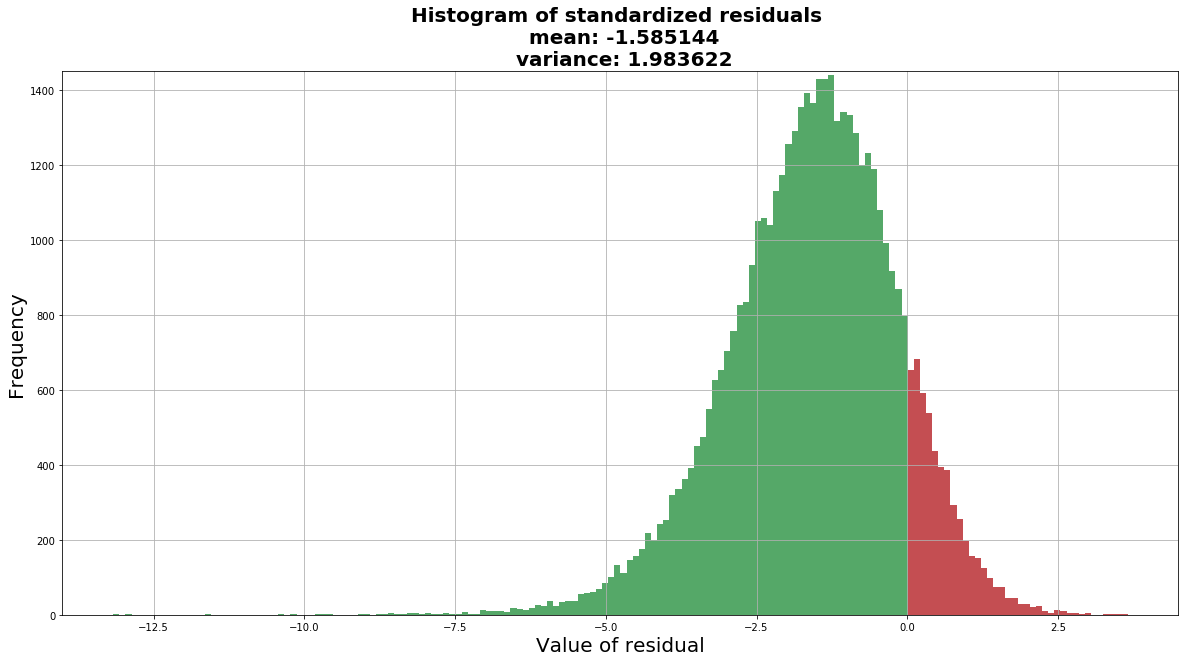

In [20]:
# Predict
predictions_custom_cmm = gbm_custom_cmm.predict(test_data=test_h2o).as_data_frame()

# Evalute and print summary
items_custom_cmm, less_custom_cmm, more_or_perfect_custom_cmm = evaluate(test, predictions_custom_cmm)
    
print_evaluation(predictions_custom_cmm, less_custom_cmm, more_or_perfect_custom_cmm)

If you combine custom distribution and custom metric together you can get again shifted residual distribution but also variance is changed.
you can change the loss function until we are satisfied with the results.

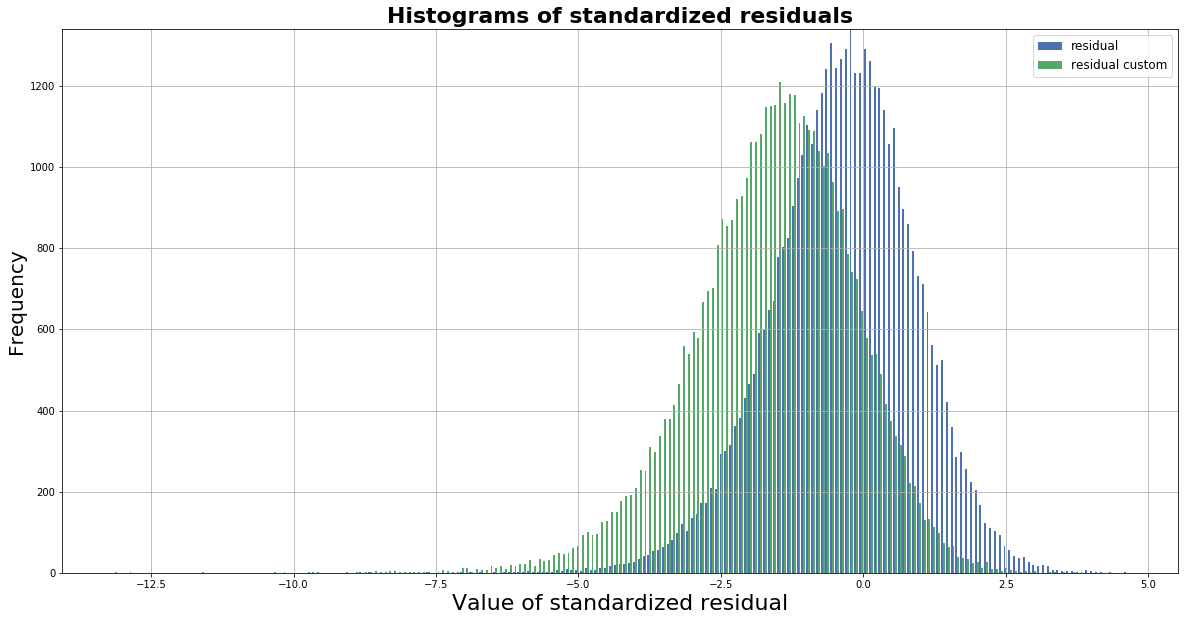

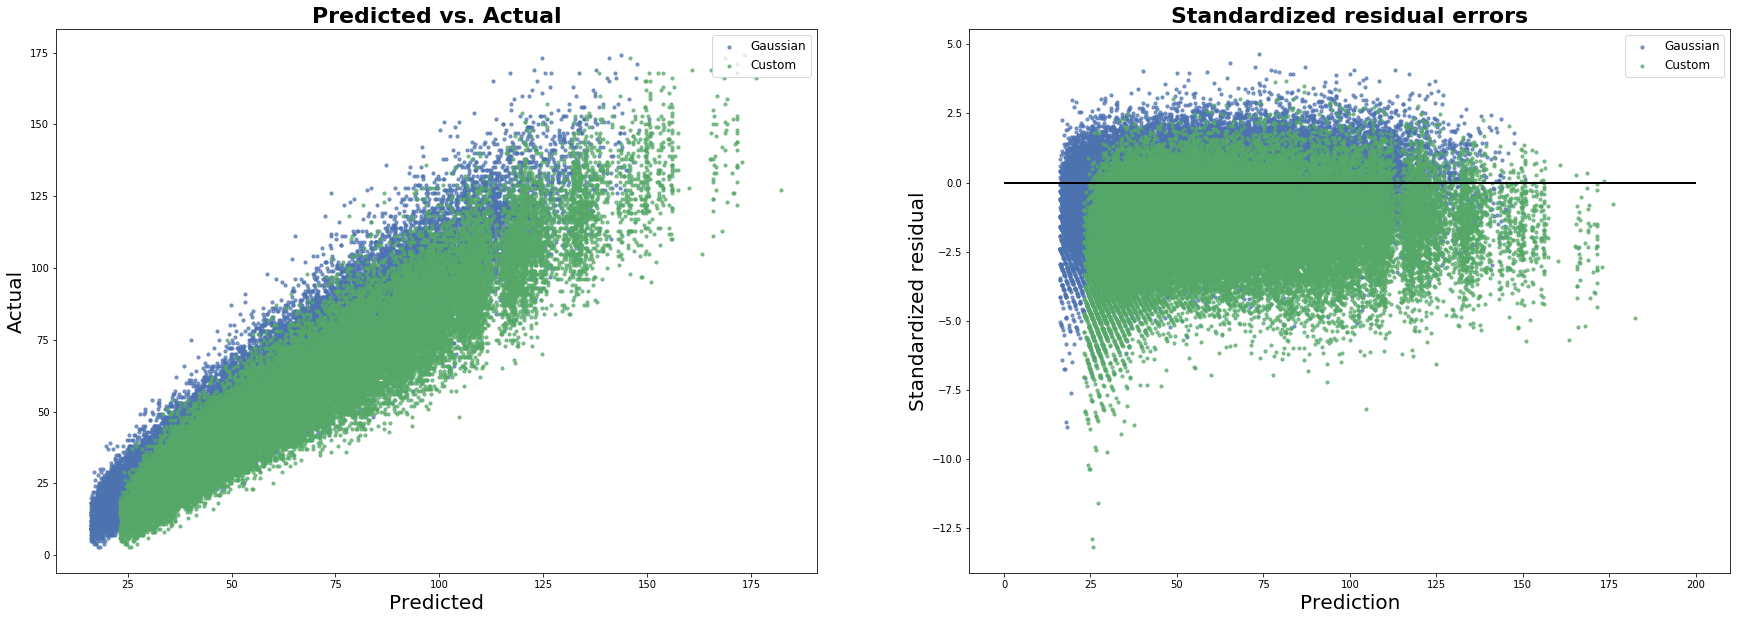

In [21]:
print_residuals(predictions_custom_mm, predictions_custom_cmm)

If you look into scoring history, you can see less tree and better result with custom distribution and custom metric combination.

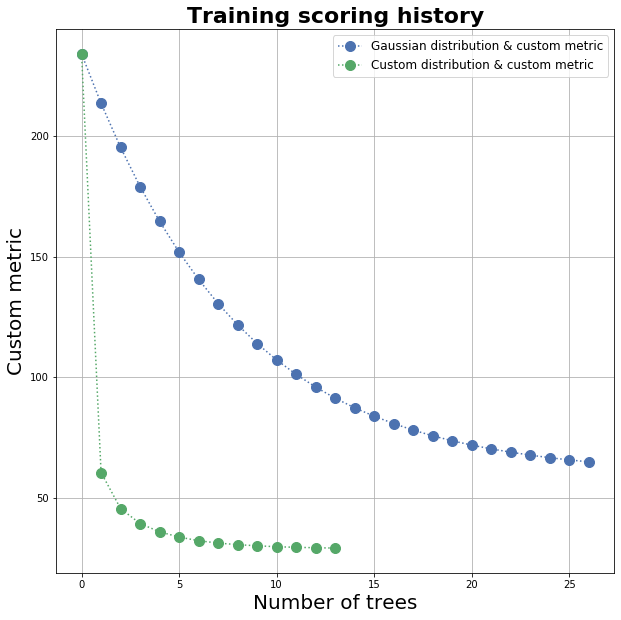

In [27]:
plot_scoring_history(gbm_custom_mm.scoring_history()["training_custom"], gbm_custom_cmm.scoring_history()["training_custom"])

Prediction (a custom distribution with custom metric together) is again larger than the predictions with Gaussian distribution and custom metric.

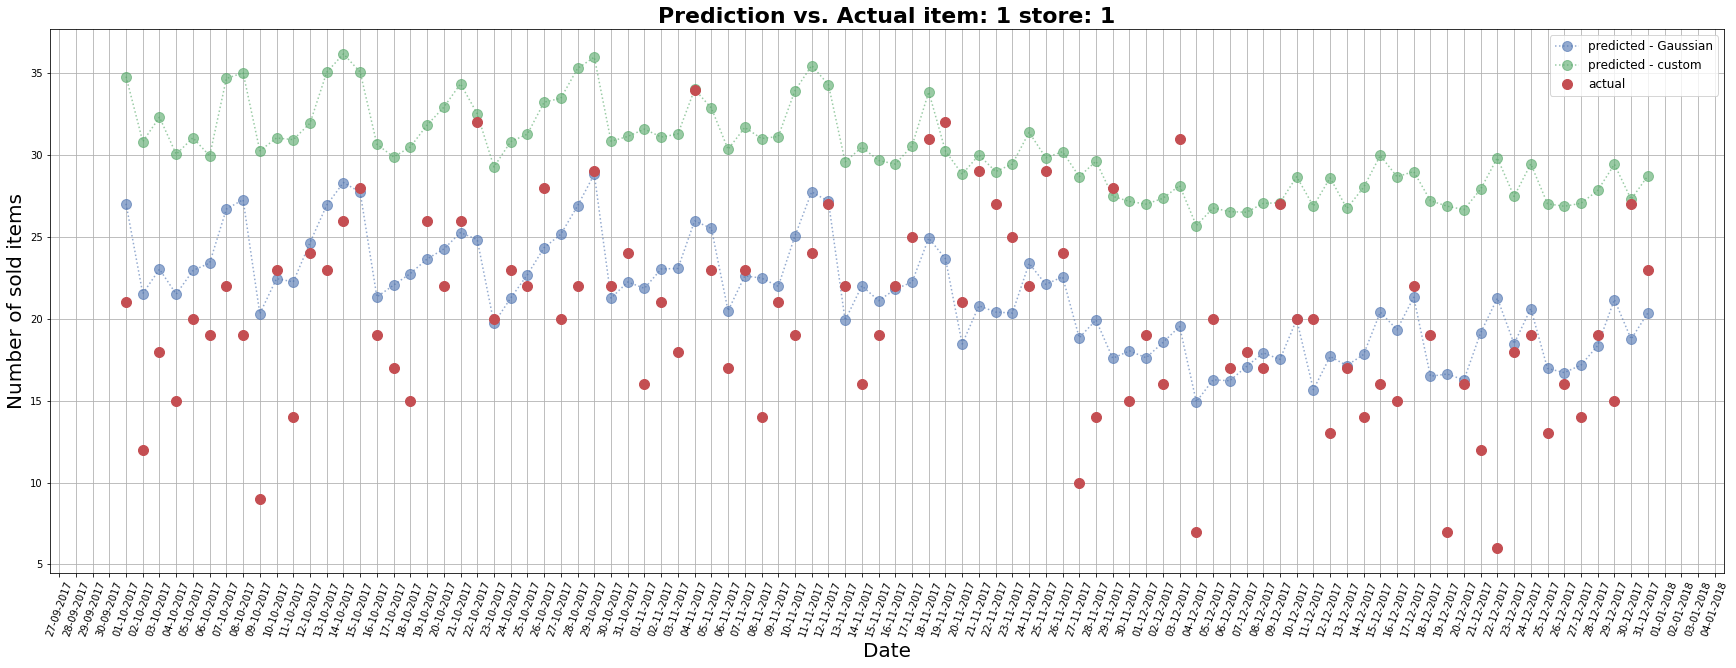

In [24]:
print_predictions(predictions, predictions_custom_cmm, 1, 1)

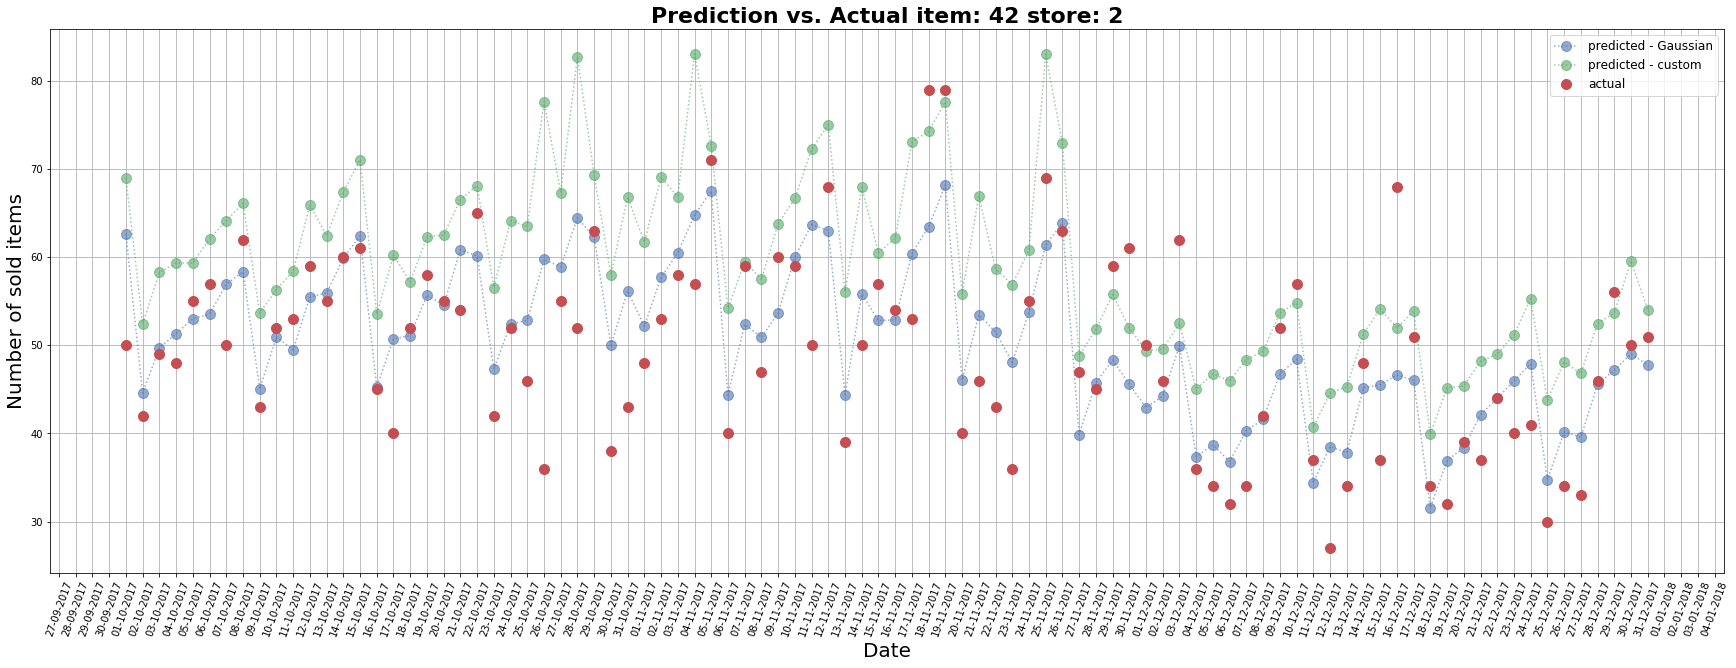

In [25]:
print_predictions(predictions, predictions_custom_cmm, 42, 2)

## Conclusion

We used a simple loss function improvement, but the result is significant. The possibility to change loss function calculation based on data knowledge can be crucial to get a better prediction model.

Thank Michal Kurka to help me implement the custom distribution feature and Vaclav Belak and Martin Barus to help me prepare this demo.